# 16 - 断点回归设计


我们很少停下来深思，但大自然之流畅确实令人赞叹。没有萌芽，树木无从生长；瞬间移动不过是幻想，伤口愈合需时日。即便在社会领域，渐进亦是常态。一日之内无法壮大企业，积累财富需持之以恒与辛勤付出，掌握线性回归的原理亦需经年累月。通常情况下，大自然环环相扣，鲜有跳跃突变。


> 载营魄抱一，能无离乎？

\- 《道德经》，老子著。

这意味着，**当我们确实观察到跳跃和尖峰时，这些现象很可能是人为制造的、非自然的情境**。这类事件通常伴随着对常规情况的反事实假设：若发生异常现象，便能为我们提供一种视角，去探究若自然规律以不同方式运作时可能产生的后果。探索这些人造跳跃点正是断点回归设计的核心所在。

![img](images/16/smooth.png)

基本设定如下所述。设想存在一个处理变量 $T$ 及潜在结果 $Y_0$ 与 $Y_1$。处理变量 T 是关于观测运行变量 $R$ 间断函数，其表达式为

$
D_i = \mathcal{1}\{R_i>c\}
$

换言之，这表明当 $R$ 低于阈值 $c$ 时处理为零，否则为一。这意味着我们能在 $R>c$ 条件下观测到 $Y_1$，而在 $R<c$ 条件下观测到 $Y_0$。为理解这一机制，可将潜在结果视为两个无法完整观测的函数。虽然 $Y_0(R)$ 和 $Y_1(R)$ 同时存在，但我们无法同时观测。阈值如同一个切换开关，使我们得以观察其中一个函数而非两者，如下图所示：

![img](images/16/rdd.png)

断点回归法的核心思想是通过比较阈值两侧紧邻处的结果变量差异，以识别阈值处的处理效应。这种方法被称为**精确断点回归设计**，因为在阈值处接受处理的概率从 0 跃升至 1；但也可考虑**模糊断点回归设计**，其概率虽同样存在跳跃，但变化幅度较为平缓。

## 酒精正在危害你的生命吗？

一个极具现实意义的公共政策问题是：最低饮酒年龄应设定为多少？包括巴西在内的大多数国家将其定为 18 岁，而美国（大部分州）现行标准为 21 岁。那么，是美国过于谨慎而应当降低饮酒年龄下限，还是其他国家应当提高其法定饮酒年龄呢？

从[死亡率](https://www.aeaweb.org/articles?id=10.1257/app.1.1.164)的角度审视这一问题不失为一种方法（Carpenter 与 Dobkin，2009）。站在公共政策的立场上，可以主张我们应尽可能降低死亡率。若酒精消费显著推高死亡率，则不应下调最低饮酒年龄。此举符合减少酒精所致死亡的目标。

为评估酒精对死亡的影响，可利用法定饮酒年龄在自然状态下造成的断点现象。在美国，刚好未满21岁的人基本不喝酒（或喝得少得多），而刚满21岁的人则开始喝酒。这意味着在21岁这个年龄点，饮酒概率出现了跃升，而我们可以利用这一点运用断点回归设计（RDD）进行研究。

```note
你也可以认为，满21岁只是提高了饮酒的概率，因为即使在21岁之前，也有可能喝酒（尽管不合法）。从技术上讲，这使得这个案例属于“模糊回归不连续设计”（Fuzzy RD Design），我们将在本章稍后进一步探讨这一点。
```

In [48]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

style.use("fivethirtyeight")

为此，我们可以获取按年龄分组的死亡率数据。每行数据代表某年龄段人群的平均年龄，以及全因死亡率（ `all` ）、机动车事故死亡率（ `mva` ）和自杀死亡率（ `suicide` ）的平均值。

```{dropdown} 查看 Stata 代码
```stata
* Load data (assuming CSV is in current directory)
import delimited "./data/drinking.csv", clear

list in 1/5

In [50]:
drinking = pd.read_csv("data/drinking.csv")
drinking.head()[["agecell", "all", "mva", "suicide"]]

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


为了便于观察（以及出于我们稍后将看到的另一个重要原因），我们将运行变量 `agecell` 以阈值 21 为中心进行居中处理。

In [52]:
drinking["agecell"] -= 21

如果我们在 x 轴上绘制多个结果变量（ `all` 、 `mva` 、 `suicide` ）与运行变量的关系图，可以直观地观察到在跨越法定饮酒年龄时死亡率存在某种跳跃。

```{dropdown} 查看 Stata 代码
```stata
//作散点图，观测跳跃
* 所有的死亡率
twoway scatter all agecell, xline(21,lp(dash)) saving(all)

* 交通死亡率
twoway scatter mva agecell, xline(21,lp(dash)) saving(mva)

* 自杀死亡率
twoway scatter suicide agecell,xline(21,lp(dash)) saving(suicide)

graph combine all.gph mva.gph suicide.gph,col(1)

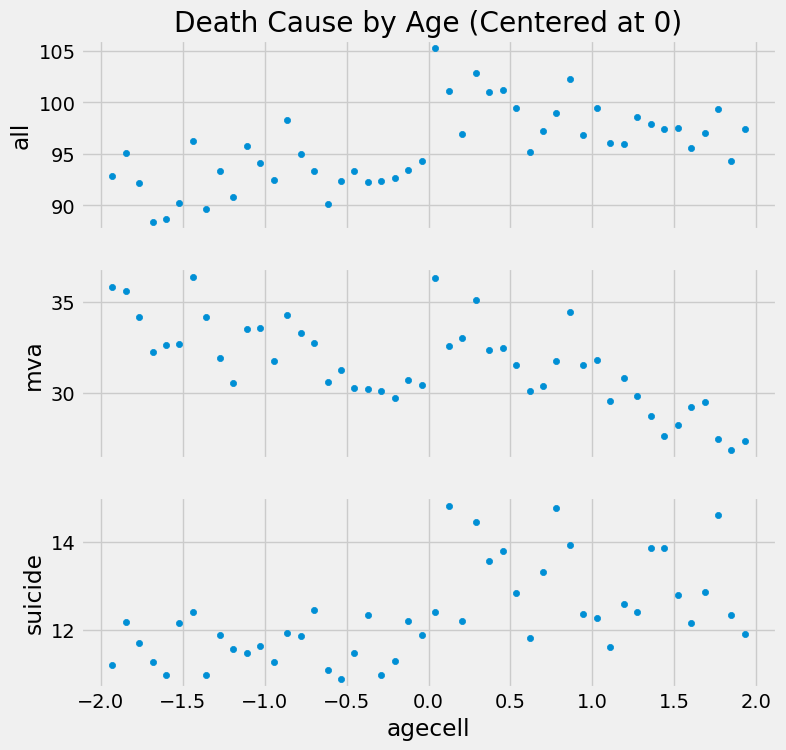

In [120]:
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
drinking.plot.scatter(x="agecell", y="all", ax=ax)
plt.title("Death Cause by Age (Centered at 0)")

ax = plt.subplot(3,1,2, sharex=ax)
drinking.plot.scatter(x="agecell", y="mva", ax=ax)

ax = plt.subplot(3,1,3, sharex=ax)
drinking.plot.scatter(x="agecell", y="suicide", ax=ax)
plt.show()

虽然有一些迹象，但这还不够。在阈值处，饮酒对死亡率的确切影响是多少？而我们对这个估计的标准误是多少？

## RDD估计

RDD 方法依赖的关键假设是在阈值处潜在结果的平滑性。形式上，当运行变量从右侧和左侧趋近阈值时，潜在结果的极限应当相同。

$$
\lim_{r \to c^-} E[Y_{ti}|R_i=r] = \lim_{r \to c^+} E[Y_{ti}|R_i=r]
$$

若此条件成立，我们便能在阈值处找到因果效应

$$
\begin{align}
\lim_{r \to c^+} E[Y_{ti}|R_i=r] - \lim_{r \to c^-} E[Y_{ti}|R_i=r]=&\lim_{r \to c^+} E[Y_{1i}|R_i=r] - \lim_{r \to c^-} E[Y_{0i}|R_i=r] \\
=& E[Y_{1i}|R_i=r] - E[Y_{0i}|R_i=r] \\
=& E[Y_{1i} - Y_{0i}|R_i=r]
\end{align}
$$

从某种意义上说，这其实是一种局部平均处理效应（LATE），因为我们只能在阈值处识别这个效应。在这种设定下，我们可以将 RDD 理解为一个局部的随机试验。对于正好处在阈值附近的人来说，是否接受处理几乎像是随机的——有些人刚好低于阈值，有些人刚好高于。这就像在同一时刻，有些人刚满 21 岁，而有些人还差几天才满 21 岁，这种差别几乎是由出生日期的“偶然性”决定的。因此，RDD 提供了一个非常有说服力的因果识别方式。它虽然不是随机对照试验（RCT）那样的“黄金标准”，但已经非常接近了。

现在，为了估计阈值处的处理效应，我们只需估计上述公式中的两个极限并进行比较。最简单的方法是通过运行线性回归来实现。

![img](images/16/ols.png)

为了使其有效，我们将一个表示“是否高于阈值”的虚拟变量与运行变量进行交互。

$
y_i = \beta_0 + \beta_1 r_i + \beta_2 \mathcal{1}\{r_i>c\} + \beta_3 \mathcal{1}\{r_i>c\} r_i
$

本质上，这等同于在阈值之上和之下分别拟合一个线性回归。参数 $\beta_0$ 代表阈值以下回归的截距，而 $\beta_0+\beta_2$ 则是阈值以上回归的截距。

此处便是将运行变量在阈值处居中的技巧发挥作用的地方。经过这一预处理步骤后，阈值变为零。这使得截距 $\beta_0$ 成为阈值下方回归的预测值。换言之，$\beta_0=\lim_{r \to c^-} E[Y_{ti}|R_i=r]$ 。同理， $\beta_0+\beta_2$ 为上方结果之极限。这意味着，

$
\lim_{r \to c^+} E[Y_{ti}|R_i=r] - \lim_{r \to c^-} E[Y_{ti}|R_i=r]=\beta_2=E[ATE|R=c]
$

下面是对应的代码示例，用于估计在21岁时，饮酒对“所有原因导致的死亡”的影响。

```{dropdown} 查看 Stata 代码
```stata
// 回归法

gen d= agecell>=21

gen running=agecell-21

reg all running d i.d#c.running,r

twoway (scatter all agecell) (lfit all agecell if agecell<=21)(lfit all agecell if agecell>=21), xline(21,lp(dash)) saving(all1,replace)

twoway (scatter mva agecell) (lfit mva agecell if agecell<=21)(lfit mva agecell if agecell>=21), xline(21,lp(dash)) saving(mva1)

twoway (scatter suicide agecell) (lfit suicide agecell if agecell<=21)(lfit suicide agecell if agecell>=21), xline(21,lp(dash)) saving(suicide1)

graph combine all1.gph mva1.gph suicide1.gph,col(1)

In [60]:
rdd_df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))

model = smf.wls("all~agecell*threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
agecell,0.8270,0.819,1.010,0.318,-0.823,2.477
threshold,7.6627,1.319,5.811,0.000,5.005,10.320
agecell:threshold,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


该模型向我们揭示，酒精消费导致死亡率上升 7.6627 个百分点。换言之，酒精使全因死亡概率增加了 8%（计算方式：100*((7.6627+93.6184)/93.6184 - 1)）。值得注意的是，该结果同时提供了因果效应估计的标准误差值。在本案例中，由于 p 值小于 0.01，该效应具有统计学显著性。

如果我们想要通过可视化来验证这个模型，可以在已有数据上展示预测值。你会发现，这就好像我们有两个回归模型：一个用于阈值以上的个体，一个用于阈值以下的个体。

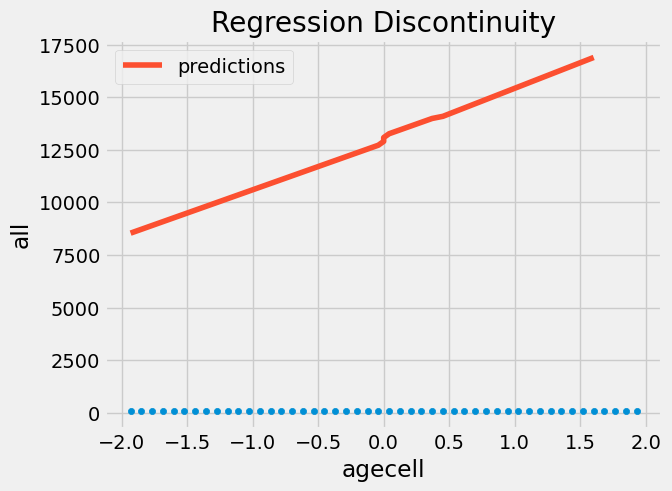

In [126]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity")
plt.show()

如果我们对其他死亡原因也进行相同的分析，得到的结果如下。

```{dropdown} 查看 Stata 代码
```stata
// 散点拟合方法来观察跳跃

twoway (scatter all agecell, msymbol(+) msize(*0.4) mcolor(black*0.3)),   title("散点图") xline(21,lp(dash)) saving(scatter, replace)

twoway (scatter all agecell) (lfit all agecell if agecell<=21)(lfit all agecell if agecell>=21), xline(21,lp(dash)) saving(scatter1, replace)

rdplot all agecell, c(21) p(1) graph_options(title(线性拟合))
graph save rd1,replace // 线性拟合图

rdplot all agecell, c(21) p(2) graph_options(title(二次型拟合)) 
graph save rd2,replace //二次型拟合图

rdplot all agecell, c(21) p(3) graph_options(title(三次型拟合)) 
graph save rd3,replace //三次型拟合图


graph combine scatter.gph scatter1.gph rd1.gph rd2.gph rd3.gph

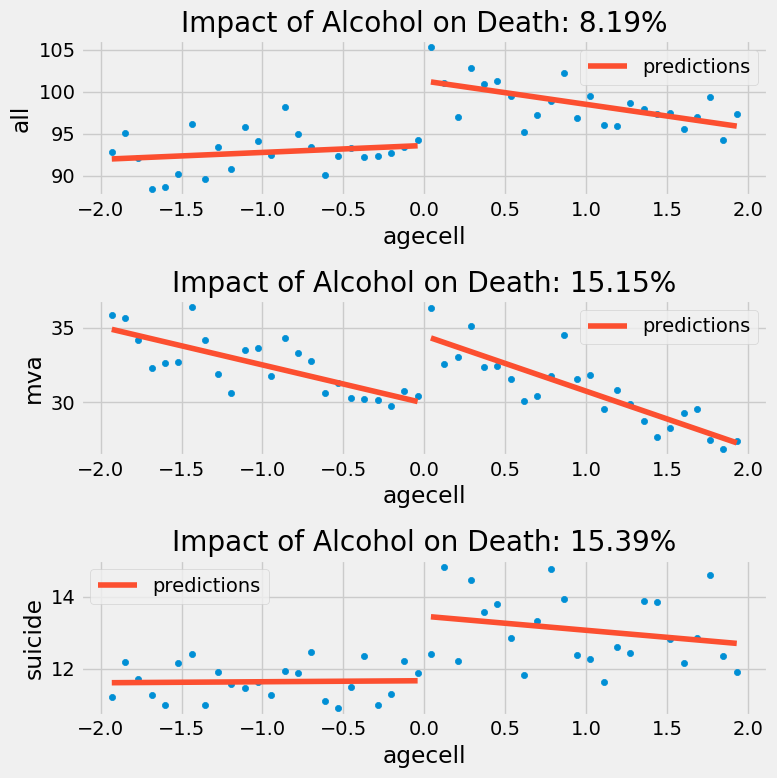

In [128]:
plt.figure(figsize=(8,8))

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()
plt.show()

RDD 分析显示，酒精会使自杀和交通事故导致的死亡风险增加 15%，这一比例相当显著。若我们的目标是尽可能降低死亡率，这些结果构成了反对降低饮酒年龄的有力论据。

### 核加权

断点回归高度依赖于线性回归的外推特性。由于我们关注的是两条回归线起点和终点的数值，必须确保这些极限值的准确性。可能出现的情况是，回归过度拟合其他数据点，导致在阈值处的拟合效果不佳。一旦发生这种情况，我们可能会得出错误的处理效应估计。

解决这一问题的一种方法是为靠近阈值的点赋予更高的权重。实现方式多种多样，其中一种常见做法是使用**三角核函数**对样本进行重新加权。

$
K(R, c, h) = \mathcal{1}\{|R-c| \leq h\} * \bigg(1-\frac{|R-c|}{h}\bigg)
$

该核函数的第一部分是一个指示函数，用于判断我们是否接近阈值。接近到什么程度？这由带宽参数 $h$ 决定。核函数的第二部分是一个加权函数。随着我们远离阈值，权重会变得越来越小。这些权重会被带宽除。如果带宽较大，权重减小的速度较慢；如果带宽较小，权重则会迅速趋近于零。

为便于理解，以下是该核函数应用于我们问题时的权重示例。此处我将带宽设为 1，意味着我们仅考虑年龄不超过 22 岁且不低于 20 岁的人群数据。

In [71]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

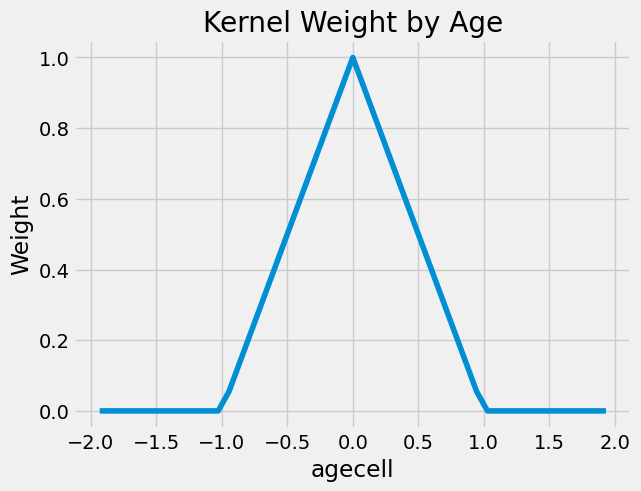

In [130]:
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age")
plt.show()

若我们将这些权重应用于原始问题，酒精的影响会变得更大，至少对所有原因而言如此。其数值从 7.6627 跃升至 9.7004，结果依然非常显著。此外，请注意我使用的是 `wls` 而非 `ols` 。

In [76]:
model = smf.wls("all~agecell*threshold", rdd_df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


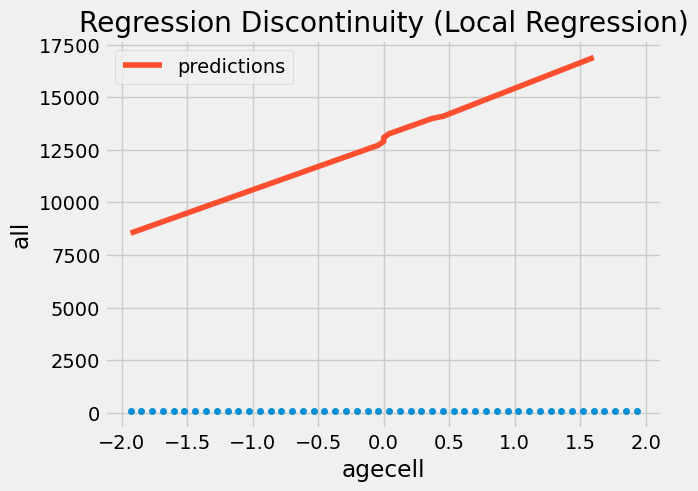

In [132]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)")
plt.show()

以下是其他死因的图示情况。请注意右侧的回归线为何呈现更负的斜率，因为它未将最右侧的点纳入考虑。

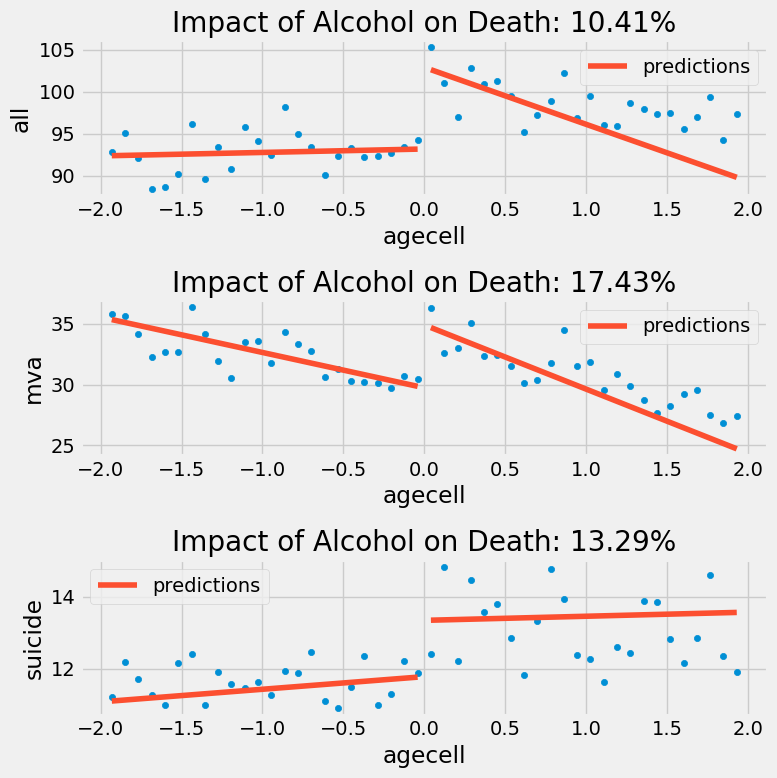

In [134]:
plt.figure(figsize=(8,8))
weights = kernel(drinking["agecell"], c=0, h=1)

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df, weights=weights).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()
plt.show()

除了自杀这一项外，加入核加权后，饮酒所带来的负面影响似乎变得更大了。再次说明，如果我们的目标是降低死亡率，那么我们不应建议降低法定饮酒年龄，因为饮酒对死亡率的影响是明显存在的。

这个简单的案例涵盖了当回归断点设计完美运作时的情况。接下来，我们将探讨一些应进行的诊断方法，以评估对 RDD 的可信度，并讨论一个我们极为关注的话题：教育对收入的影响。

## 羊皮效应与模糊断点回归设计

在探讨教育对收入的影响时，经济学界存在两大主要观点。第一种广为人知的论点认为，教育能提升人力资本，进而提高生产力，最终增加收入。这一观点主张教育实质上使人变得更好。另一种观点则认为，教育仅是一种信号传递机制，它通过一系列艰难测试和学术任务来筛选人才。若能成功完成，即向市场传递出你是一名优秀员工的信号。依此看来，教育并未直接提升你的生产力，而是向市场揭示了你原有的生产力水平。关键在于文凭——持有文凭者将获得更高报酬。这种现象被称为 **“羊皮纸效应”** ，因过去文凭常印制于羊皮纸上而得名。

为了验证这一假设，[Clark and Martorell](https://faculty.smu.edu/millimet/classes/eco7321/papers/clark%20martorell%202014.pdf)采用断点回归法来衡量完成 12 年级学业对收入的影响。为此，他们需要设定一个临界变量，高于该值的学生能够毕业，而低于该值的学生则不能。他们在德克萨斯州的教育体系中找到了这样的数据。

为了在德克萨斯州毕业，学生必须通过一项考试。测试从十年级开始，学生可以多次尝试，但最终，他们在十二年级结束时面临最后一次机会考试。研究的构想是从参加这些最后一次机会考试的学生中获取数据，并将那些勉强未通过的学生与那些勉强通过的学生进行比较。这些学生将拥有非常相似的人力资本，但信号凭证不同。具体而言，那些勉强通过的学生将获得文凭。

In [89]:
sheepskin = pd.read_csv("./data/sheepskin.csv")[["avgearnings", "minscore", "receivehsd", "n"]]
sheepskin.head()

,avgearnings,minscore,receivehsd,n
0,11845.086,-30.0,0.416667,12
1,9205.679,-29.0,0.387097,31
2,8407.745,-28.0,0.318182,44
3,11114.087,-27.0,0.377778,45
4,10814.624,-26.0,0.306667,75


再次强调，此数据按运行变量分组。它不仅包含运行变量（最低分数，已以零为中心）和结果（平均收入），还包含了该分数段获得文凭的概率及样本量（n）。例如，在分数阈值以下-30 分的单元格中，12 名学生里仅有 5 人成功取得文凭（12*0.416）。

这意味着在治疗分配上存在一定的滑移现象。一些未达到及格门槛的学生仍然设法获得了文凭。此处，回归断点呈现**模糊性**而非精确性。注意到获得文凭的概率并未在门槛处从零跃升至一，而是从约 50% 跃升至 90% 。

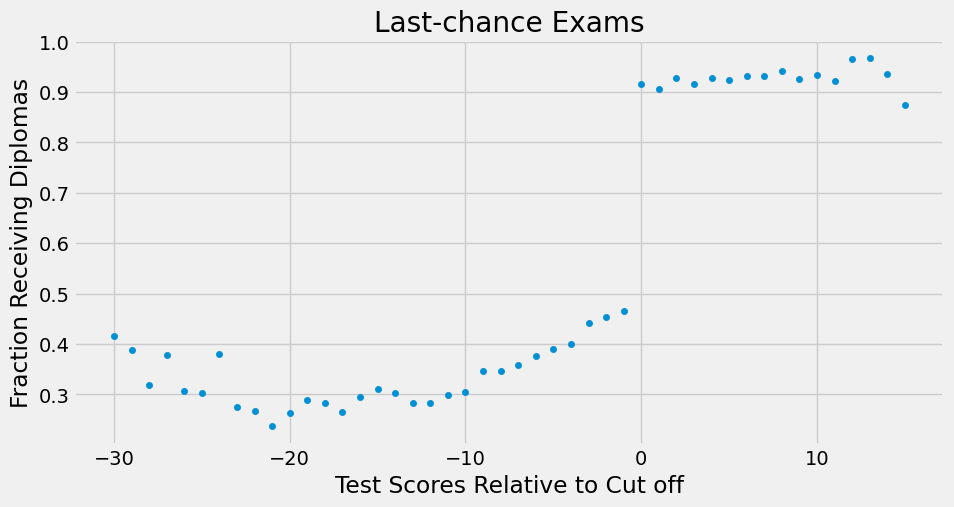

In [136]:
sheepskin.plot.scatter(x="minscore", y="receivehsd", figsize=(10,5))
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Fraction Receiving Diplomas")
plt.title("Last-chance Exams")
plt.show()

我们可以将模糊断点回归视为一种不遵从行为。越过阈值本应让每个人都获得文凭，但有些学生，即那些从不接受者，并未得到它。同样，低于阈值本应阻止你获得文凭，但有些学生，即那些总能接受者，却设法无论如何都拿到了文凭。

就像我们拥有潜在结果一样，在此情境下我们也拥有潜在的处理状态。$T_1$ 代表若所有人都高于阈值时将接受的处理；$T_0$ i则是若所有人都低于阈值时将接受的处理。或许你已经注意到，我们可以将**阈值视为一个工具变量**。正如在工具变量法中，若我们简单地估计处理效应，结果会偏向于零。

![img](images/16/rdd_fuzzy.png)

即使在阈值以上，接受处理的概率仍然小于 1，这会导致我们观察到的结果低于真实的潜在结果 $Y_1$。同样地，在阈值以下，我们观察到的结果高于真实的潜在结果 $Y_0$。这使得阈值处的处理效应看起来比实际要小。为了纠正这种偏误，我们需要使用工具变量（IV）技术。

正如我们先前对潜在结果假设了平滑性，现在我们也对潜在处理做出同样的假设。此外，与工具变量（IV）方法中类似，我们需要假设单调性。若您已不记得，单调性指的是 $T_{i1}>T_{i0} \ \forall i$。这意味着从左至右跨越阈值仅会增加获得文凭的机会（或者说不存在违背者）。基于这两个假设，我们得到了局部平均处理效应（LATE）的沃尔德估计量。

$$
\dfrac{\lim_{r \to c^+} E[Y_i|R_i=r] - \lim_{r \to c^-} E[Y_i|R_i=r]}{\lim_{r \to c^+} E[T_i|R_i=r] - \lim_{r \to c^-} E[T_i|R_i=r]} = E[Y_{1i} - Y_{0i} | T_{1i} > T_{0i}, R_i=c]
$$

请注意，这里的估计在两种意义上是局部的。首先，它是局部的，因为它仅给出阈值 $c$处的处理效应。这是断点回归（RD）的局部性。其次，它是局部的，因为它仅估计了遵从者的处理效应。这是工具变量（IV）的局部性。

为了估计这一点，我们将使用两个线性回归。分子的估计可以像之前一样进行。至于分母，我们只需将结果变量替换为处理变量。但首先，我们需要进行一项合理性检验，以确保可以信任我们的断点回归设计（RDD）估计结果。

### 麦克雷利检验

可能破坏我们断点回归论证的一个情况是，人们能够操纵自己在阈值附近的位置。以文凭效应为例，如果刚好低于阈值的学生找到系统漏洞，将考试成绩略微提高，就会发生这种情况。另一个例子是，当家庭需要低于特定收入水平才能获得政府福利时，部分家庭可能会故意降低收入，刚好达到项目资格线。

在这些情况下，我们往往会观察到一种称为“聚集”的现象出现在运行变量的密度上。这意味着会有大量实体恰好位于阈值之上或之下。为了检验这一点，我们可以绘制运行变量的密度函数图，查看阈值附近是否存在尖峰。就我们的案例而言，密度由数据中的 `n` 列给出。

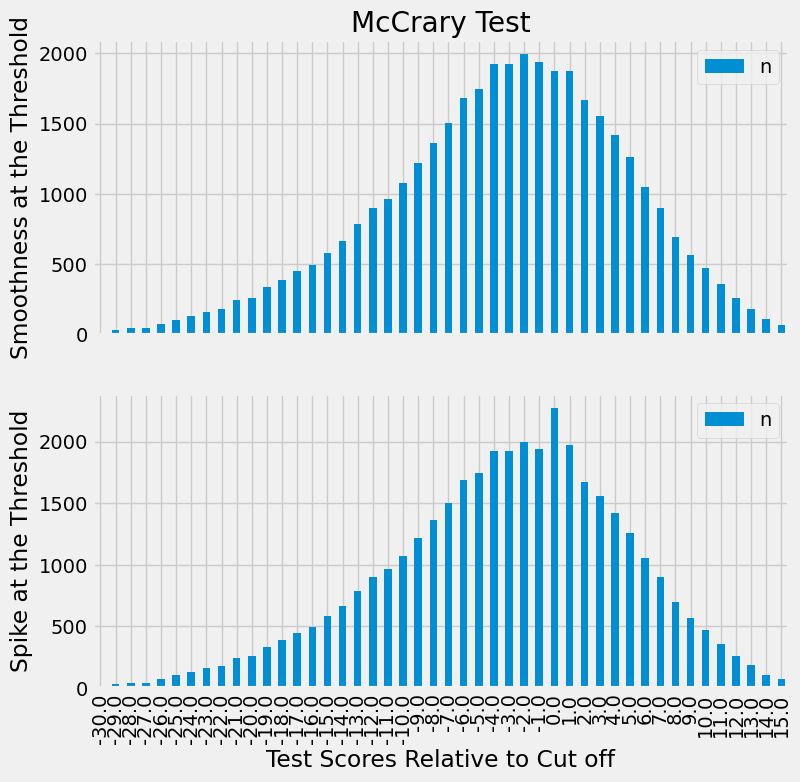

In [138]:
plt.figure(figsize=(8,8))

ax = plt.subplot(2,1,1)
sheepskin.plot.bar(x="minscore", y="n", ax=ax)
plt.title("McCrary Test")
plt.ylabel("Smoothness at the Threshold")

ax = plt.subplot(2,1,2, sharex=ax)
sheepskin.replace({1877:1977, 1874:2277}).plot.bar(x="minscore", y="n", ax=ax)
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Spike at the Threshold")
plt.show()

第一幅图展示了我们数据密度的分布情况。如图所示，阈值附近并无峰值出现，这意味着不存在聚集现象。学生们并未操控自己在阈值上的位置分布。仅作说明之用，第二幅图展示了若学生能操控阈值位置时可能出现的聚集形态——我们会在略高于阈值的区间观察到密度峰值，因为会有大量学生恰好卡在这个及格线上。

在解决这个问题之后，我们可以回过头来估计羊皮纸效应。正如我之前所说，沃尔德估计量的分子可以像在锐利断点回归中那样进行估计。这里，我们将使用带宽为 15 的核函数作为权重。由于我们还拥有单元格大小，我们将核函数乘以样本量，从而得到该单元格的最终权重。

In [106]:
sheepsking_rdd = sheepskin.assign(threshold=(sheepskin["minscore"]>0).astype(int))
model = smf.wls("avgearnings~minscore*threshold",
                sheepsking_rdd,
                weights=kernel(sheepsking_rdd["minscore"], c=0, h=15)*sheepsking_rdd["n"]).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.399e+04,83.678,167.181,0.000,1.38e+04,1.42e+04
minscore,181.6636,16.389,11.084,0.000,148.588,214.739
threshold,-97.7571,145.723,-0.671,0.506,-391.839,196.325
minscore:threshold,18.1955,30.311,0.600,0.552,-42.975,79.366


这表明文凭的效应为-97.7571，但这一结果在统计上并不显著（P 值为 0.5）。若绘制这些结果，我们会在阈值处得到一条极为连续的线。受教育程度更高的人群确实收入更高，但在获得 12 年级文凭的节点上并未出现跳跃性变化。这一发现支持了教育通过提升个人生产力而非仅作为市场信号来增加收入的观点。换言之，不存在所谓的羊皮纸效应。

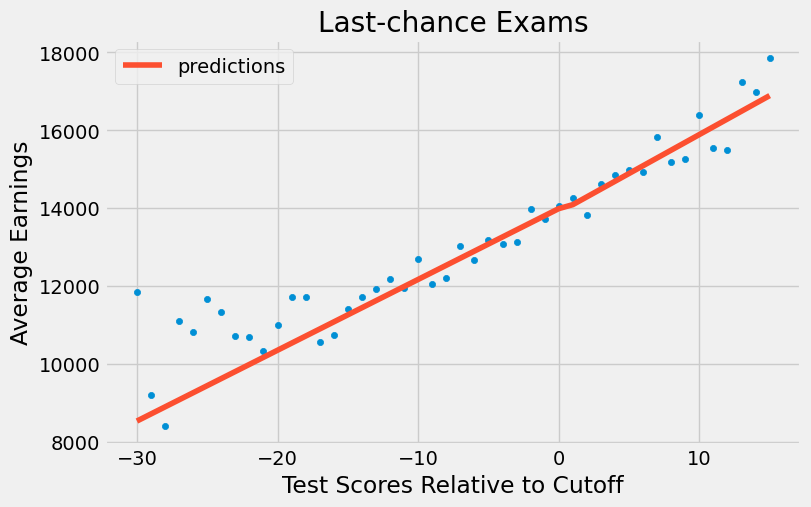

In [140]:
ax = sheepskin.plot.scatter(x="minscore", y="avgearnings", color="C0")
sheepskin.assign(predictions=model.fittedvalues).plot(x="minscore", y="predictions", ax=ax, color="C1", figsize=(8,5))
plt.xlabel("Test Scores Relative to Cutoff")
plt.ylabel("Average Earnings")
plt.title("Last-chance Exams")
plt.show()

然而，正如我们从非依从性偏误机制中所知，该结果存在向零的偏误。为校正此问题，需通过第一阶段结果进行缩放并计算沃尔德估计量。遗憾的是，目前缺乏优质的 Python 实现方案，因此我们需手动完成这一过程，并采用自助法来获取标准误。

下方代码如同先前操作般运行沃尔德估计量的分子部分，同时通过将目标变量替换为处理变量 `receivehsd` 来构建分母。最后一步仅需将分子除以分母即可。

In [112]:
def wald_rdd(data):
    weights=kernel(data["minscore"], c=0, h=15)*data["n"]
    denominator = smf.wls("receivehsd~minscore*threshold", data, weights=weights).fit()
    numerator = smf.wls("avgearnings~minscore*threshold", data, weights=weights).fit()
    return numerator.params["threshold"]/denominator.params["threshold"]

In [114]:
from joblib import Parallel, delayed 

np.random.seed(45)
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(wald_rdd)(sheepsking_rdd.sample(frac=1, replace=True))
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

利用自助法（bootstrap）生成的样本，我们可以绘制平均处理效应（ATE）的分布图，并观察其95%置信区间所在的位置。

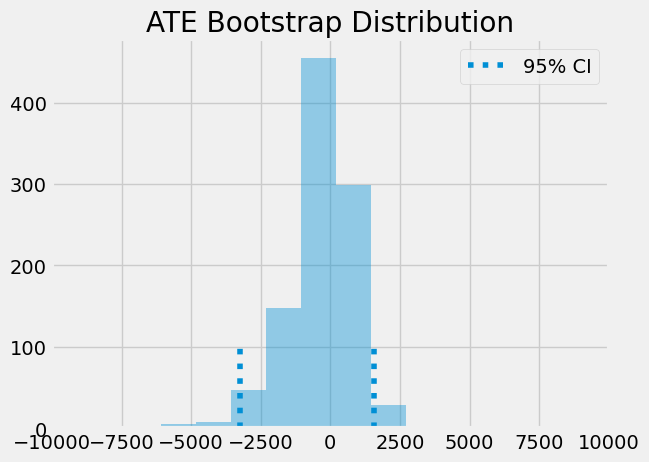

In [142]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 100, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 100, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.xlim([-10000, 10000])
plt.legend()
plt.show()

```{dropdown} 查看 Stata 代码
```stata
// 断点回归
rdplot all agecell,c(21)
* 局部线性回归
* ssc install rdrobust,replace
rdrobust all agecell,c(21) all

rdbwselect all agecell,c(21) all

rdplot all agecell,c(21) ci(95)

* 局部多项式回归

rdrobust all agecell,c(21) all p(1)

rdrobust all agecell,c(21) all p(2)

rdrobust all agecell,c(21) all p(3)

*全局多项式回归

sum agecell
local hvalueR=r(max)  
local hvalueL= abs(r(min))
 
rdrobust all agecell, c(21)  h(`hvalueL'  `hvalueR') all //自动选择阶数
rdrobust all agecell, c(21)  h(`hvalueL'  `hvalueR') all p(2) //二阶拟合
rdrobust all agecell, c(21)  h(`hvalueL'  `hvalueR') all p(3) //三阶拟合

* McCrary Test
rddensity agecell,c(21) plot bwselect(each)


// 模糊断点

import delimited "/Users/xuwenli/Library/CloudStorage/OneDrive-个人/DSGE建模及软件编程/教学大纲与讲稿/应用计量经济学讲稿/python-causality-handbook/causal-inference-for-the-brave-and-true/data/sheepskin.csv", clear

list in 1/5

twoway scatter receivehsd minscore, xline(0,lp(dash)) saving(all)

// 断点回归

rdrobust receivehsd minscore, all

rdbwselect receivehsd minscore, all

rdplot receivehsd minscore, ci(95)

rddensity minscore, all plot

如你所见，即便我们将效应按第一阶段进行缩放，其与零的统计差异仍不显著。这意味着教育并非通过简单的文凭效应增加收入，而是通过提升个人生产力来实现。

## 核心要点

我们学习了如何利用人为的不连续性来估计因果效应。其核心思想在于设定一个人为阈值，使得处理概率在此处发生跃变。例如，我们观察到年龄达到 21 岁时饮酒概率的骤增现象，借此可估算饮酒对死亡率的影响。该方法基于一个关键事实：在阈值附近，情境近乎随机实验。处于阈值边缘的个体本可能落入任一侧，最终归属实则随机。通过比较阈值两侧的个体，我们能够获得处理效应。我们还探讨了如何运用带核函数的加权线性回归实现这一分析，并自然地得到平均处理效应（ATE）的标准误。

接着，我们考察了模糊断点回归设计（fuzzy RD）中出现不遵从行为时的情况。研究发现，可以采用与工具变量（IV）法相似的思路来处理此类问题。




## 参考文献
我愿将这一系列作品视为对 Joshua Angrist、Alberto Abadie 和 Christopher Walters 杰出计量经济学课程的致敬。第一部分的大部分思想源自他们在美国经济学会授课的内容。在艰难的 2020 年，正是观看他们的课程视频让我保持了理智。

 - [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
 - [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

 我还想引用 Angrist 的精彩著作。它们向我展示了计量经济学（他们称之为“Metrics”）不仅极为实用，而且充满乐趣。
 - [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
 - [Mastering ‘Metrics](https://www.masteringmetrics.com)

最后还要感谢 Miguel Hernán 和 Jamie Robins 的[《Causal Inference》](https://hsph.harvard.edu/profile/miguel-hernan/)一书。它是我在面对最棘手的因果问题时的可靠伙伴。

![img](./images/poetry.png)

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。